In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@39350246444e-c5b7003f00984eb8b2d925333b827430: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@39350246444e-c5b7003f00984eb8b2d925333b827430: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
root@39350246444e-c5b7003f00984eb8b2d925333b827430: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@39350246444e-c5b7003f00984eb8b2d925333b827430: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 1175
root@39350246444e-c5b7003f00984eb8b2d925333b827430: cat /tmp/tmpvvgnne64/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferences=

In [2]:
import os
os.chdir('./drive/MyDrive/python_project/dacon_hand')

In [3]:
# ! unzip ./new_open.zip -d ./open

In [4]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model

# GPU 환경 설정
import os

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [5]:
data_path = './open'

train_path = data_path + '/train'
test_path = data_path + '/test'
crop_train_path = data_path + '/crop_train'
crop_test_path = data_path + '/crop_test'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [6]:
# Train 데이터에 있는 폴더를 glob로 불러와
# sorted method를 통해 숫자 순으로 정렬합니다.
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_train_folders = sorted(glob(crop_train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_test_folders  = sorted(glob(crop_test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_folders[:5]

['./open/train/0',
 './open/train/1',
 './open/train/2',
 './open/train/3',
 './open/train/4']

In [7]:
train_folder = train_folders[0]
crop_train_folder = crop_train_folders[0]

image_paths = sorted(glob(crop_train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
json_path   = glob(train_folder + '/*.json')[0]

In [8]:
image_paths

['./open/crop_train/0/0.png',
 './open/crop_train/0/1.png',
 './open/crop_train/0/2.png',
 './open/crop_train/0/3.png',
 './open/crop_train/0/4.png',
 './open/crop_train/0/5.png',
 './open/crop_train/0/6.png',
 './open/crop_train/0/7.png',
 './open/crop_train/0/8.png']

(566, 566, 3)


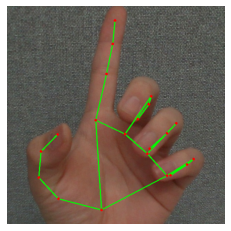

In [9]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [10]:
js = json.load(open(json_path))

print("json keys             : ", js.keys())

print("json actor info       : ",js.get('actor'))

print("json image info       : ",js.get('image'))

print("json annotations keys : ",js.get('annotations')[0].keys())

json keys             :  dict_keys(['action', 'actor', 'id', 'annotations'])
json actor info       :  None
json image info       :  None
json annotations keys :  dict_keys(['image_id', 'data'])


In [11]:
# answers = []
# for train_folder in train_folders :
#     json_path = glob(train_folder + '/*.json')[0]
#     js = json.load(open(json_path))
#     cat = js.get('action')[0]  # 수정
#     cat_name = js.get('action')[1]  # 수정
#     answers.append([train_folder.replace(data_path,''),cat, cat_name])

# answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
# answers

In [12]:
# answers.to_csv('./answers.csv', index=False)

In [13]:
answers = pd.read_csv('./answers.csv')
answers

,train_path,answer,answer_name
0,/train/0,0,숫자 1
1,/train/1,0,숫자 1
2,/train/2,10,숫자 1
3,/train/3,10,숫자 1
4,/train/4,10,숫자 1
...,...,...,...
644,/train/644,194,빅토리
645,/train/645,195,부정(엄지손 아래로)
646,/train/646,195,부정(엄지손 아래로)
647,/train/647,195,부정(엄지손 아래로)


In [14]:
answers['answer_name'].value_counts()

약속             46
전화모양           30
손 안경           30
빅토리            27
손바닥            24
부정(엄지손 아래로)    23
최고             23
OK             23
총              22
동그라미           22
파이팅            21
부정(검지 흔들기)     20
손가락 접기         20
약지,소지 가위       20
엄지,중지 붙이기      18
엄지,약지 붙이기      15
손가락 오므리기       14
경고(주먹 내밀기)     13
검지,중지 교차       13
엄지,소지 붙이기      13
꼬집기            12
손 토끼           12
숫자 9           11
숫자 8           11
숫자 4           11
숫자 0           11
숫자 3           11
숫자 5           10
숫자7             9
숫자8             9
숫자 2            9
숫자 7            9
숫자 6            8
숫자0             7
주먹쥐기            7
숫자 1            7
네모              6
숫자2             6
숫자1             6
숫자4             5
세모              5
X               5
숫자9             5
숫자6             5
손하트             4
큰하트             4
숫자3             4
숫자5             3
Name: answer_name, dtype: int64

In [15]:
len(answers['answer_name'].unique())

48

In [16]:
answers['answer'].unique()

array([  0,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,   1,  22,
        23,  25,  26,  27,  28,  29,   2,  31,  32,  34,  35,  36,  37,
        39,   3,  40,  41,  42,  43,  44,  47,  48,  49,   4,  50,  51,
        53,  54,  55,  56,  57,  58,  59,   5,  60,  61,  62,  64,  65,
        66,  67,  68,  69,   6,  70,  72,  73,  74,  75,  77,  78,  79,
         7,  80,  81,  82,  83,  85,  87,  88,  89,   8,  90,  92,  93,
        94,  95,  97,  98,   9, 100, 101, 105, 106, 107, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126,
       128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 165, 167, 168, 169, 171,
       172, 173, 174, 175, 177, 186, 188, 189, 190, 191, 192, 193, 194,
       195])

In [17]:
classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()

In [18]:
classes.shape

(649, 157)

In [19]:
np.random.shuffle(crop_train_folders) # 일반화 가능성 높이기

In [20]:
# images  = []
# targets = []
# for train_folder in tqdm(crop_train_folders) :
#     image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
#     query_path  = train_folder.replace(data_path,'')
#     target = classes[int(train_folder.split('/')[-1])] 
#     for image_path in image_paths:
#         img = image.load_img(image_path, target_size=(224,224,3))
#         img = image.img_to_array(img)
#         img = img/255
#         images.append(img)
#         targets.append(target)

In [21]:
# np.save('./crop_img', np.array(images))
# np.save('./crop_targets', np.array(targets))

In [22]:
images = np.load('./crop_img.npy')
targets = np.load('./crop_targets.npy')

In [23]:
X = images
print('Train X Shape : ', X.shape)

y = targets
print('Train y Shape : ', y.shape)


Train X Shape :  (5880, 224, 224, 3)
Train y Shape :  (5880, 157)


In [24]:
learning_rate = 5e-4
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [25]:
! pip install -U tensorflow-addons

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [27]:
data_augmentation = tf.keras.Sequential(
    [
        # layers.Normalization(),
        # layers.Resizing(image_size, image_size),
         tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
         tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(X)

In [28]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [29]:
class Patches(layers.Layer):
    def __init__(self, patch_size=patch_size, **kwargs):
        
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size


    def get_config(self):
        config = super().get_config().copy()
        # config.update({
        #     'patch_size' : self.patch_size
        # })

        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


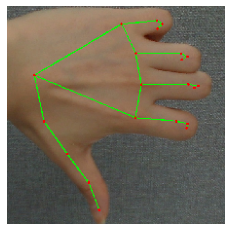

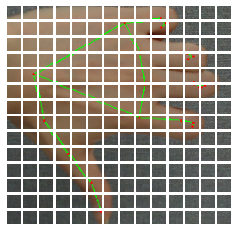

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X[np.random.choice(range(X.shape[0]))] * 255
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [31]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=num_patches, projection_dim=projection_dim, **kwargs):

        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )


    def get_config(self):
        config = super().get_config().copy()
        # config.update({
        #     'num_patches' : self.num_patches,
        #     'projection' : self.projection,
        #     'position_embedding' : self.position_embedding
        # })

        return config


    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)

        return encoded

In [32]:
num_classes = classes.shape[1]
print(num_classes)
input_shape = (224, 224, 3)

157


In [33]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)

    return model

In [34]:
from keras.callbacks import Callback
from keras import backend as K
import math
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, n_epochs, lr_max, lr_min, n_cycle, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.n_epochs = n_epochs
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.n_cycle = n_cycle
        self.lrates = list()
        self.verbose = verbose
        
    def cosine_annealing(self, epoch):
        
        epochs_per_cycle = math.floor(self.n_epochs/self.n_cycle)
        cos_inner = (math.pi * (epoch % (epochs_per_cycle))) / (epochs_per_cycle)
        
        return (self.lr_max - self.lr_min)/2 * (tf.math.cos(cos_inner) + 1) + self.lr_min
     
    def plot(self, epoch):
        lr = self.cosine_annealing(epoch)
        self.lrates.append(lr)
        
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.cosine_annealing(epoch)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose == 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [35]:
max_rate = 5e-4
min_rate = 1e-4
cycle = 10

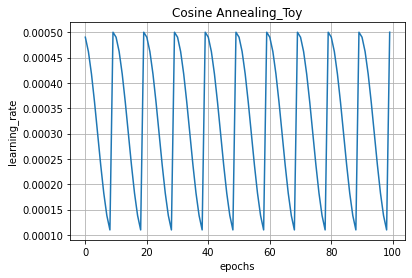

In [36]:
cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)

for i in range(1, num_epochs + 1):
    cosine_scheduler.plot(i)

plt.plot(cosine_scheduler.lrates)
plt.title('Cosine Annealing_Toy')
plt.xlabel('epochs'); plt.ylabel('learning_rate')
plt.grid()
plt.show()

In [40]:
! pip install adabelief_tf 
from adabelief_tf import AdaBeliefOptimizer
AdaBelief = AdaBeliefOptimizer(learning_rate=5e-4, epsilon=1e-16, weight_decay=1e-4)

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



------------------------------------------------------------------------
Training for fold 1 ...
(1176, 157)


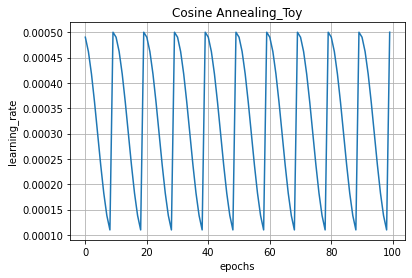

Epoch 1/100

Epoch 00001: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.00049999997, shape=(), dtype=float32).
74/74 [==============================] - 44s 170ms/step - loss: 6.0640 - accuracy: 0.0053 - top-5-accuracy: 0.0317 - val_loss: 5.0531 - val_accuracy: 0.0102 - val_top-5-accuracy: 0.0476

Epoch 00001: val_loss improved from inf to 5.05308, saving model to ./model/vit_01-5.0531_fold:1.hdf5
Epoch 2/100

Epoch 00002: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.0004902113, shape=(), dtype=float32).
74/74 [==============================] - 11s 152ms/step - loss: 5.1508 - accuracy: 0.0087 - top-5-accuracy: 0.0366 - val_loss: 5.0529 - val_accuracy: 0.0068 - val_top-5-accuracy: 0.0374

Epoch 00002: val_loss improved from 5.05308 to 5.05287, saving model to ./model/vit_02-5.0529_fold:1.hdf5
Epoch 3/100

Epoch 00003: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.00046180337, shape=(), dtype=float32).
74/74 [==============================]

KeyboardInterrupt: ignored

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# kfold = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

fold_no = 1
for train, val in skf.split(X, np.argmax(y, axis=1)):

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    train_x = X[train]
    train_y = y[train]
    valid_x = X[val]
    valid_y = y[val]
    print(np.array(valid_y).shape)

    

    cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)

    for i in range(1, num_epochs + 1):
        cosine_scheduler.plot(i)

    plt.plot(cosine_scheduler.lrates)
    plt.title('Cosine Annealing_Toy')
    plt.xlabel('epochs'); plt.ylabel('learning_rate')
    plt.grid()
    plt.show()


    model = create_vit_classifier()


    optimizer = AdaBelief

    model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
    )


    modelpath = "./model/vit_{epoch:02d}-{val_loss:.4f}_fold:%d.hdf5" % fold_no

    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, 
                                                    save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7)

    history = model.fit(
        train_x,
        train_y,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(valid_x, valid_y),
        callbacks=[checkpointer, early_stopping_callback,cosine_scheduler]
    )

    fold_no += 1


In [ ]:
model_name1 = 'vit_30-0.0187_fold:1.hdf5'
model1 = load_model('./model/%s' % model_name1, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
model_name2 = 'vit_39-0.0243_fold:2.hdf5'
model2 = load_model('./model/%s' % model_name2, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
model_name3 = 'vit_40-0.0192_fold:3.hdf5'
model3 = load_model('./model/%s' % model_name3, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
model_name4 = 'vit_30-0.0512_fold:4.hdf5'
model4 = load_model('./model/%s' % model_name4, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
model_name5 = 'vit_28-0.0370_fold:5.hdf5'
model5 = load_model('./model/%s' % model_name5, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})

In [ ]:
# from tensorflow.keras.preprocessing import image
# test_images  = []
# for test_folder in tqdm(crop_test_folders, total = len(crop_test_folders)) :
#     image_paths = sorted(glob(test_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
#     query_path  = test_folder.replace(data_path,'')
#     test_image = []
#     for image_path in image_paths:
#         img = image.load_img(image_path, target_size=(224,224,3))
#         img = image.img_to_array(img)
#         img = img/255
#         test_image.append(img)
#     test_images.append(test_image)

# test_images = np.array(test_images)
# print(test_images.shape)

In [ ]:
# np.save('./crop_test_images', np.array(test_images))

In [ ]:
test_images = np.load('./crop_test_images.npy',allow_pickle=True)
print(test_images.shape)

In [ ]:
print(np.array(test_images.shape))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = test_images[np.random.choice(range(test_images.shape[0]))][0] * 255
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
all_model = [model1, model2, model3, model4, model5]

In [ ]:
sub=np.zeros((test_images.shape[0], num_classes))  

for model in all_model:
    predictions = []
    for test_image in tqdm(test_images, total = len(test_images)) : 
        prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
        predictions.append(prediction)

    sub+=predictions

mean_sub = sub/len(all_model)
mean_sub

In [ ]:
predictions_label = []
for i in mean_sub:

    predictions_label.append(np.argmax(i))

In [ ]:
sample_submission.iloc[:,1:] = mean_sub
display(sample_submission.head())
sample_submission.to_csv('./sibmit/vti_kfold_%s.csv' % model_name1, index=False)

In [ ]:
predictions_label

In [ ]:
answer_num = list(answers['answer'].unique())
answer_num

In [ ]:
len(predictions_label)

In [ ]:
for i in range(test_images.shape[0]):
    image = test_images[i][0] * 255

    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    plt.show()
    
    print(f"answer_num: {answer_num[predictions_label[i]]}")
    try:
        print(list(answers['answer_name'][answers['answer']==(answer_num[predictions_label[i]])])[0])
    except:
        print('없음')
        pass



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
id = 
image = test_images[np.random.choice(range(test_images.shape[0]))][0] * 255
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")